# Single Task Learning (STL) based VGG model: Age Group classification in facial images

Here, two STL based VGG models are used for age group classifcation in UTKFace data (Song, Zhang and Qi, 2017). The convolutional base of each model is extracted from VGG16 model (Simonyan and Zisserman, 2015) and the Imagenet weights (Deng, 2009) are used to initialize this VGG16 convolutional base. <br>

Model architecture used:  VGG16 base + [128 nodes] + [5 output nodes]. <br>
Batch size = 32 <br>
Learning rate = 0.0001 <br>
<br>
Model details: <br>
Model 1: VGG conv base is frozen (the 5th block made trainable)<br>
Model 2: VGG conv base is fully trainable

The 5 output nodes corresponds to 5 different age groups as follows:
<br>

| Age Group     | Year Range     |
|---------------|----------------|
| Child         | 0-14    |
| Youth         | 14-25   |
| Adult         | 25-40   |
| Middle Age    | 40-60   |
| Old           | 60+     |

The following shows the required imports to run this colab file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.utils import plot_model
from tensorflow import keras

Now, the seed is set to a random integer so that same sequence of random numbers are generated each time the programme is run.

In [2]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(seed)

Here, my Google Drive is connected to this Colab file.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Below folder contains the cropped faces of the UTKFace data (Song, Zhang and Qi, 2017) from the "RetinaFace" algorithm (Deng et al., 2020). This deep learning based algorithm was used to extract faces with a fixed spatial resolution of 100 x 100 and save them in RGB image form.

In [4]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"

Following shows the total number of facial images stored in the folder.

In [5]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


The following code divides the age range into 5 different age categories as Child, Youth, Adult, Middle Age and Old. The age ranges of the above categories are as follows: <br>

| Age Group     | Year Range     |
|---------------|----------------|
| Child         | 0-14    |
| Youth         | 14-25   |
| Adult         | 25-40   |
| Middle Age    | 40-60   |
| Old           | 60+     |

Then, the age group distribution of the UTKFace data (Song, Zhang and Qi, 2017) used in this study is shown separately and along with gender.

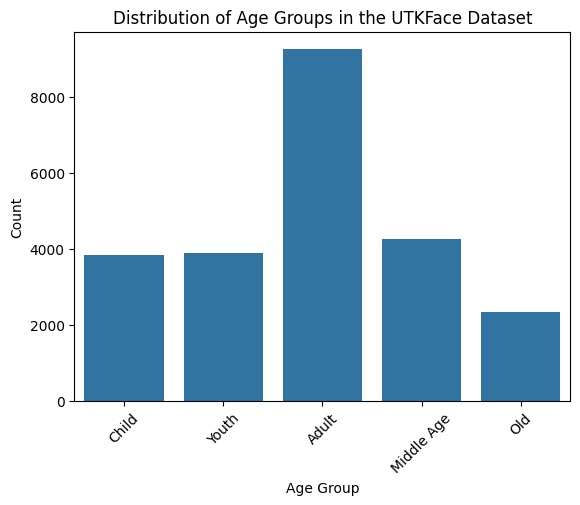

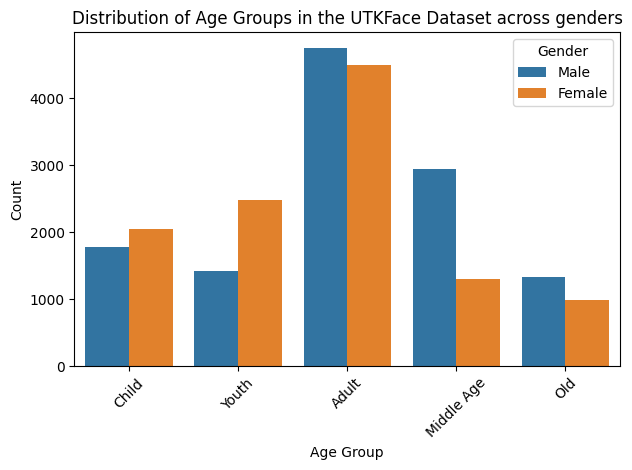

In [6]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

# Age distribution
# Defining bins and labels
bins = [0, 14, 25, 40, 60, 116]
labels = ["Child", "Youth", "Adult", "Middle Age", "Old"]

# Classifying ages into groups
DFrame['Age_Group'] = pd.cut(DFrame['Age'], bins=bins, labels=labels, right=True)  # (0, 14], (14,25], (25, 40], (40, 60] and (60, 116]

# Plotting the distribution of age groups
fig1, ax1 = plt.subplots()
sns.countplot(x='Age_Group', data=DFrame, ax=ax1)
ax1.set_title('Distribution of Age Groups in the UTKFace Dataset')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')

# Race Mapping
gender_mapping = {
    0 : 'Male',
    1 : 'Female'
}
# Replacing the integers with correct gender
DFrame['Gender'] = DFrame['Gender'].replace(gender_mapping)

# Plotting the distribution of age groups with gender
fig1, ax2 = plt.subplots()
sns.countplot(x='Age_Group', hue='Gender', data=DFrame, ax=ax2)
ax2.set_title('Distribution of Age Groups in the UTKFace Dataset across genders')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')

# Rotating x-tick labels for both axes
for label in ax1.get_xticklabels():
  label.set_rotation(45)  # Rotating x-tick labels by 45 degrees

for label in ax2.get_xticklabels():
  label.set_rotation(45)  # Rotating x-tick labels by 45 degrees

plt.tight_layout()
plt.show()

The following function "labeling_age_group_tf" returns the age group label given the age and a tensor called bins containing bin locations. Since the age groups are divided into 5 categories, bins = [0, 14, 25, 40, 60, 116] which indicate the boundaries of age groups. The given age is checked in each defined age group and recorded its state in a boolean tensor. The location where the boolean tensor is true gives the integer label associated with each age group.

The inter mapping of age group is as follows:

| Age Group     | Year Range     | Integer Label  |
|---------------|----------------|----------------|
| Child         | 0-14           |       0        |
| Youth         | 14-25          |       1        |
| Adult         | 25-40          |       2        |
| Middle Age    | 40-60          |       3        |
| Old           | 60+            |       4        |

In [7]:
def labeling_age_group_tf(age, bins):
    # Converting bins and age to TensorFlow constants
    bins = tf.constant(bins, dtype=tf.int32)

    # Creating labels from 0 to len(bins) - 2
    age_groups = tf.range(len(bins) - 1, dtype=tf.int32)

    # Finding the appropriate age group
    conditions = tf.logical_and(age > bins[:-1], age <= bins[1:])
    label = tf.reduce_sum(tf.where(conditions, age_groups, 0))

    return label

Each facial image is labeled in the format age_gender_race_date&time.jpg. The function "read_image" splits the label of an image and separately returns age group labels along with the associated facial image.

In [8]:
def read_image(fname):
    # Extracting label from file name
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]
    multiple_labels = tf.strings.split(file_name, '_')

    # Converting age label to integer
    age_label = tf.strings.to_number(multiple_labels[0], out_type=tf.int32)     # First part: age

    # Defining age bins
    bins = [0, 14, 25, 40, 60, 116]
    # Extracting labels (age, gender, race)
    age_group_label =  labeling_age_group_tf(age_label, bins)  # First part: age

    # Loading and decoding the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, age_group_label

The below function normalizes the the facial images

In [9]:
def preprocess_image(image, age_group_label):
    # Converting image to float32 and normalize to [0,1]
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, age_group_label

This below code splits a dataset of file paths into training (80%), validation (10%), and test (10%) sets using TensorFlow's tf.data.Dataset API. It starts by listing all files in a specified folder and shuffling them for randomness with a fixed seed for reproducibility. The dataset is then divided: the first 80% of files are taken for training, the next 10% for validation, and the remaining 10% for testing.

In [10]:
# Creating training, validation and test sets.
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Defining split sizes
train_size = int(0.8 * file_count)  # 80% for training
val_size = int(0.1 * file_count)    # 10% for validation
test_size = file_count - train_size - val_size  # Remaining 10% for testing

# Shuffling the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Splitting into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 80% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 10% for validation
test_list_ds = list_ds.skip(train_size + val_size)  # Remaining 10% for test

The training, validation and test datasets are created with a batch size of 32. Each dataset is prepared by mapping file paths to images using read_image, followed by applying preprocessing with preprocess_image. Then, the datasets are batched, cached for faster reuse, and prefetched to improve performance by preparing the next batch while the current one is being processed. The use of tf.data.AUTOTUNE optimizes parallelism and performance.

In [11]:
batch_size = 32
lr= 0.0001

# Dataset preparation with preprocessing
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_group_lbl:
        preprocess_image(img, age_group_lbl),  # Applying preprocessing
        num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
    )

val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_group_lbl:
        preprocess_image(img, age_group_lbl),  # Applying preprocessing
        num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
    )

test_ds = (
    test_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, age_group_lbl:
        preprocess_image(img, age_group_lbl),  # Applying preprocessing
        num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
    )

The folllowing function compiles the STL based VGG model for age group classification using the Adam optimizer with a learning rate of 0.0001. It defines a SparseCategoricalCrossentropy loss for age group classification. Then it trains the model for 30 epochs using the train_ds dataset and evaluates its performance on the val_ds dataset at the end of each epoch. The training is performed in batches of size 32. Three callbacks are used: mc_callback, lr_callback and early_stopping. The mc_callback saves the model with the highest validation accuracy as the best model while lr_callback dynamically adjusts the learning rate during training. As the epochs goes beyond 20, the learning rate decays exponentially. Early stopping callback will stop training the model if validation accuracy does not improve within 5 consecutive epochs.

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler
def model_compile_and_fit(model, lr, train_ds, epochs, val_ds, batch_size, file_name):
  # Compiling the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
          loss=losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics=["accuracy"])
  # My model’s last layer has a softmax activation, thus from_logits=False

  # Defining the checkpoint path in Google Drive
  checkpoint_dir = '/content/drive/MyDrive/model_checkpoints/'
  # Defining the checkpoint path
  checkpoint_path = os.path.join(checkpoint_dir, file_name)

  # Creating the checkpoint callback
  mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy',
                              save_best_only=True, mode='max')
  def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * float(tf.math.exp(-0.01))
  lr_callback = LearningRateScheduler(scheduler)

  # Adding early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

  history = model.fit(
      train_ds,
      epochs=epochs,
      validation_data=val_ds,
      batch_size=batch_size,
      callbacks=[mc_callback, lr_callback, early_stopping]
  )
  return history, checkpoint_path, mc_callback

**This function prints about the model parameters, model size and trainable and frozen layers and their output shape.**

In [13]:
def print_about_model(model):
  # Get trainable and non-trainable parameters
  trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
  non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])
  total_params = model.count_params()

  trainable_percent = np.round(trainable_params / total_params *100 ,2)

  frame = pd.DataFrame({'Trainable Params': trainable_params,
                        'Non-trainable Params': non_trainable_params,
                        'Total Params': total_params,
                        'Trainable Param %':trainable_percent}, index=[0])
  print(frame)
  # Calculate size in bytes
  model_size_bytes = total_params * 4  # 4 bytes per parameter (float32)

  # Convert to kilobytes
  model_size_kb = model_size_bytes / (1024)
  print(f"Model Size in KB: {model_size_kb:.2f} KB")

  # Convert to megabytes
  model_size_mb = model_size_bytes / (1024 ** 2)
  print(f"Model Size in MB: {model_size_mb:.2f} MB")
  print("")
  print("------- About model layers ------------------------------------------")
  # Printing layer numbers and details
  cnt = 1
  for layer in model.layers:
    output_shape = layer.output.shape if hasattr(layer, 'output') else 'Not Applicable'
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}, Output Shape: {output_shape}')
    cnt += 1

The following function plots training and validation losses and accuracies.

In [14]:
def plotting_losses_accuracies_y_adjusted(history):

  fig, ax = plt.subplots(figsize=(6, 4))  # Creating a single plot
  # Plotting combined training and validation losses
  ax.plot(history.history['loss'], label='loss', marker='o')
  ax.plot(history.history['val_loss'], label = 'val_loss', marker='s')
  # Setting labels, title, and legend
  ax.set_title('Training and validation losses')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_ylim([0, 1])
  ax.legend()
  plt.show()

  fig, ax = plt.subplots(figsize=(6, 4))  # Creating a single plot
  # Plotting combined training and validation accuracies
  ax.plot(history.history['accuracy'], label='loss', marker='o')
  ax.plot(history.history['val_accuracy'], label = 'val_loss', marker='s')
  # Setting labels, title, and legend
  ax.set_title('Training and validation accuracies')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_ylim([0, 1])
  ax.legend()
  plt.show()


  # fig, axs = plt.subplots(1,2, figsize=(10, 5))
  # plt.subplots_adjust(hspace=0.1, wspace=0.5)
  # axs[0].plot(history.history['loss'], label='loss', marker='o')
  # axs[0].plot(history.history['val_loss'], label = 'val_loss', marker='s')
  # axs[0].set_xlabel('Epoch')
  # axs[0].set_ylabel('Loss')
  # axs[0].set_ylim([0, 1])
  # axs[0].legend(loc='upper right')

  # axs[1].plot(history.history['accuracy'], label='accuracy', marker='o')
  # axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy', marker='s')
  # axs[1].set_xlabel('Epoch')
  # axs[1].set_ylabel('Accuracy')
  # axs[1].set_ylim([0, 1])
  # axs[1].legend(loc='lower right')

In [15]:
def plotting_losses_accuracies(history):
  fig, ax = plt.subplots(figsize=(6, 4))  # Creating a single plot
  # Plotting combined training and validation losses
  ax.plot(history.history['loss'], label='loss', marker='o')
  ax.plot(history.history['val_loss'], label = 'val_loss', marker='s')
  # Setting labels, title, and legend
  ax.set_title('Training and validation losses')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()
  plt.show()

  fig, ax = plt.subplots(figsize=(6, 4))  # Creating a single plot
  # Plotting combined training and validation accuracies
  ax.plot(history.history['accuracy'], label='loss', marker='o')
  ax.plot(history.history['val_accuracy'], label = 'val_loss', marker='s')
  # Setting labels, title, and legend
  ax.set_title('Training and validation accuracies')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.legend()
  plt.show()

  # fig, axs = plt.subplots(1,2, figsize=(10, 5))
  # plt.subplots_adjust(hspace=0.1, wspace=0.5)
  # axs[0].plot(history.history['loss'], label='loss', marker='o')
  # axs[0].plot(history.history['val_loss'], label = 'val_loss', marker='s')
  # axs[0].set_xlabel('Epoch')
  # axs[0].set_ylabel('Loss')
  # axs[0].legend(loc='upper right')

  # axs[1].plot(history.history['accuracy'], label='accuracy', marker='o')
  # axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy', marker='s')
  # axs[1].set_xlabel('Epoch')
  # axs[1].set_ylabel('Accuracy')
  # axs[1].legend(loc='lower right')

The following function evaludates the model performance on the test dataset.

In [16]:
def model_test_results(model, checkpoint_path):
  #Loading the weights of the model with best validation accuracy
  model.load_weights(checkpoint_path)
  test_loss, test_acc = model.evaluate(test_ds, verbose=2)
  print("")
  print(f"test_loss = {np.round(test_loss,4)}, test_acc = {np.round(test_acc,4)}")

The following function visualises 25 predictions made by the model on the test data.

In [30]:
def visualising_predictions(model, test_ds):

  string_labels = ['Child', 'Young', 'Adult', 'Middle Age', 'Old']
  # First, get predictions for validation images
  predicted_scores = model.predict(test_ds)
  predicted_labels = np.argmax(predicted_scores, axis=1)

  # Convert numerical labels back to class names
  index_to_label = [string_labels[label] for label in predicted_labels]

  # Initialize lists to store images and labels
  true_labels = []
  images = []

  # Loop through test_ds to collect images and labels
  for image_batch, label_batch in test_ds:
      images.append(image_batch.numpy())  # Convert to NumPy array
      true_labels.append(label_batch.numpy())

  # Convert the list of arrays into a single NumPy array for each
  images = np.concatenate(images, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Select 25 random indices from the test set
  random_indices = np.random.choice(len(images), size=25, replace=False)

  # Plot the selected images with predicted and true labels
  f, ax = plt.subplots(5, 5, figsize=(7, 7))
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  ax = ax.ravel()

  for i, idx in enumerate(random_indices):
      ax[i].imshow(images[idx])
      ax[i].set_title(f"Pred: {string_labels[predicted_labels[idx]]}\nTrue: {string_labels[true_labels[idx]]}")
      ax[i].title.set_size(8)
      ax[i].axis('off')

  plt.show()
  return predicted_labels, true_labels

The following function plots the confusion matrix of the model's predictions on the test dataset.

In [18]:
def plot_confusion_matrix(predicted_labels, true_labels):
  y_pred= [label for label in predicted_labels]
  y_true = [label for label in true_labels]

  classes = np.arange(2)
  cm = confusion_matrix(y_true, y_pred, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(cmap='Reds')
  return y_pred, y_true

The following function generates the classification report on the model's predictions on the test dataset.

In [19]:
def generate_classification_report(y_pred, y_true):
  # Use classification_report to get precision and recall
  classification_report_result = classification_report(y_true, y_pred)
  print("\nClassification Report:")
  print(classification_report_result)

## STL Model 1 : Age Group Classification

Input image shape: (100, 100, 3)

This model has a VGG16 convolutional base with five blocks, each containing multiple convolutional layers followed by max-pooling to progressively extract spatial features while reducing dimensionality. Pre-trained weights from Imagenet are loaded into this base model to leverage learned representations. All layers in the base model are frozen to preserve these pre-trained features except the 5th block. Then a fully connected layer (FC1) with 128 nodes is attached along with an output layer with 2 nodes to classify age groups in UTKFace data (Song, Zhang and Qi, 2017). <br>

Model: VGG16 conv base (frozen except 5th block) + [128] + [out]
<br>where out layer consists of 5 nodes for age group classification.

In [20]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(seed)

from tensorflow.keras.applications import vgg16
img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')
# Load the vgg16 model with pre-trained Imagenet weights and without the top classification layer
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model.layers[:15]:
  layer.trainable = False

# Age group Classification
flatten = layers.GlobalAveragePooling2D()(base_model.output)
age_group = layers.Dense(128, activation='relu', name='age_fc1')(flatten)
age_group_out = layers.Dense(5, activation='softmax', name='age_output')(age_group)

# Single-task Model
model = models.Model(inputs=base_model.input, outputs=[age_group_out], name='st_model_1')

# Printing the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "st_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ age_fc1 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 7,145,733 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Printing about the model details

In [21]:
print_about_model(model)

   Trainable Params  Non-trainable Params  Total Params  Trainable Param %
0           7145733               7635264      14780997              48.34
Model Size in KB: 57738.27 KB
Model Size in MB: 56.39 MB

------- About model layers ------------------------------------------
1: input_layer - Frozen, Output Shape: (None, 100, 100, 3)
2: block1_conv1 - Frozen, Output Shape: (None, 100, 100, 64)
3: block1_conv2 - Frozen, Output Shape: (None, 100, 100, 64)
4: block1_pool - Frozen, Output Shape: (None, 50, 50, 64)
5: block2_conv1 - Frozen, Output Shape: (None, 50, 50, 128)
6: block2_conv2 - Frozen, Output Shape: (None, 50, 50, 128)
7: block2_pool - Frozen, Output Shape: (None, 25, 25, 128)
8: block3_conv1 - Frozen, Output Shape: (None, 25, 25, 256)
9: block3_conv2 - Frozen, Output Shape: (None, 25, 25, 256)
10: block3_conv3 - Frozen, Output Shape: (None, 25, 25, 256)
11: block3_pool - Frozen, Output Shape: (None, 12, 12, 256)
12: block4_conv1 - Frozen, Output Shape: (None, 12, 12, 512)
13

Plotting the model structure

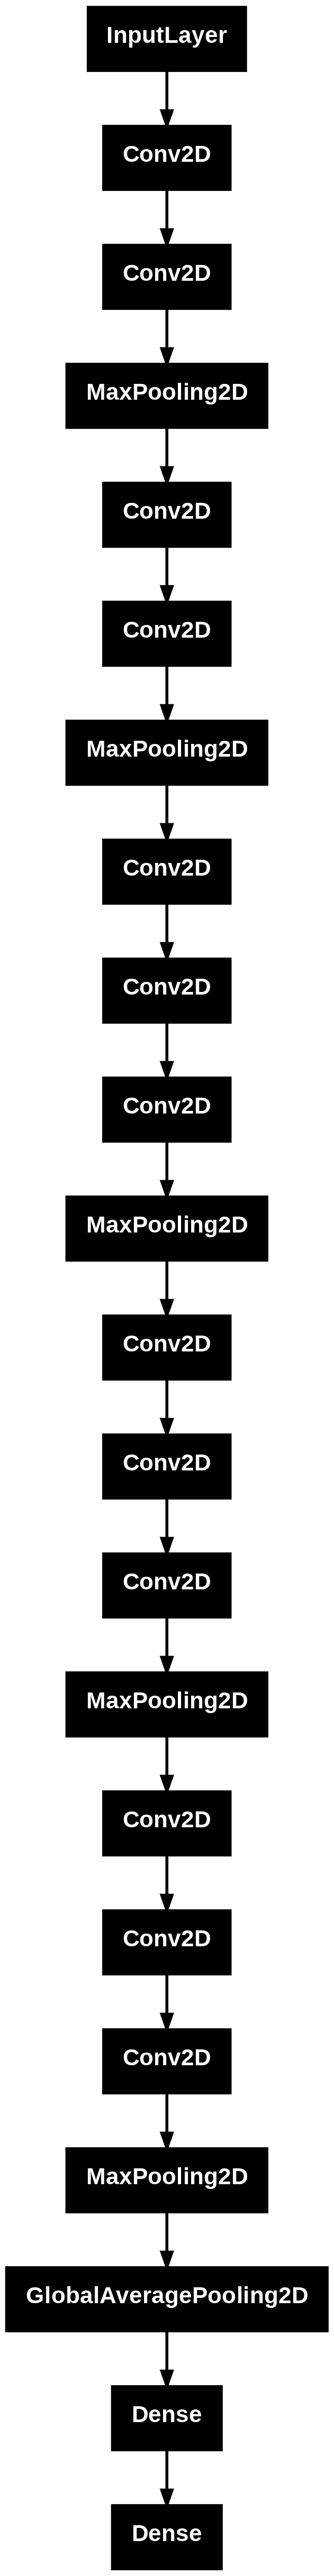

In [22]:
plot_model(model)

Compiling and training the model

In [23]:
history, checkpoint_path, mc_callback = model_compile_and_fit(model, lr=lr, train_ds=train_ds, epochs=30, val_ds=val_ds, batch_size=batch_size,
                                                              file_name="STL_VGGmodel_agegroup_classification_v1.keras")

Epoch 1/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.5419 - loss: 1.0874 - val_accuracy: 0.6757 - val_loss: 0.7761 - learning_rate: 1.0000e-04
Epoch 2/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.6523 - loss: 0.7935 - val_accuracy: 0.7135 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 3/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.7021 - loss: 0.6868 - val_accuracy: 0.7458 - val_loss: 0.6090 - learning_rate: 1.0000e-04
Epoch 4/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.7555 - loss: 0.5730 - val_accuracy: 0.7844 - val_loss: 0.5440 - learning_rate: 1.0000e-04
Epoch 5/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.8081 - loss: 0.4623 - val_accuracy: 0.7946 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 6/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.8524 - loss: 0.3667 - val_accuracy: 0.8349 - val_loss: 0.4470 - learning_rate: 1.0000e-04
Epoch 7/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step

Plotting losses and accuracies of the model

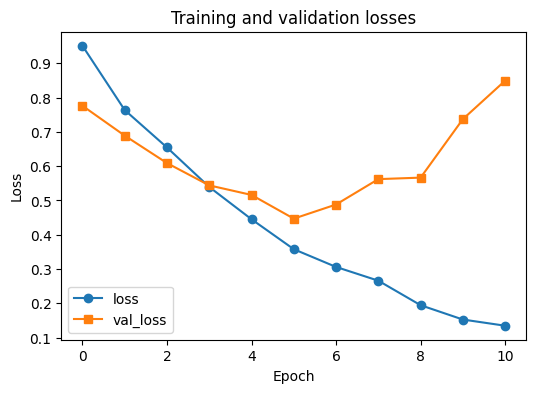

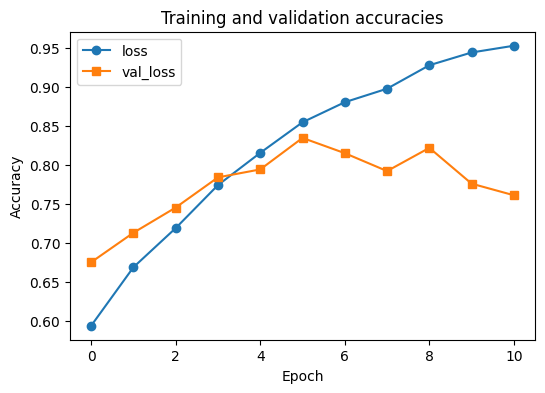

In [24]:
plotting_losses_accuracies(history)

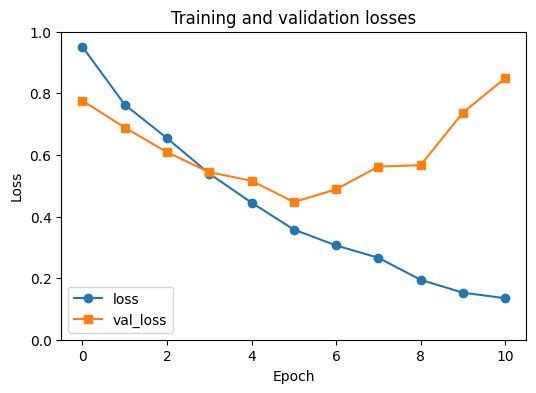

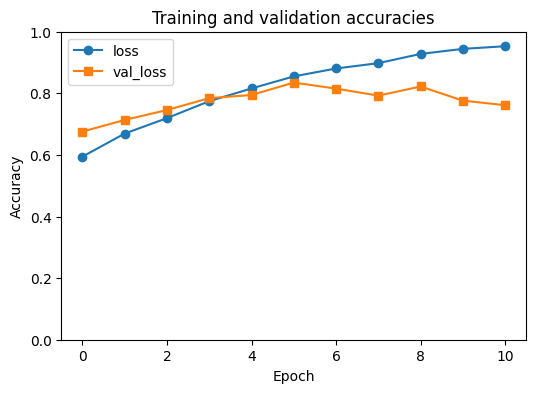

In [25]:
plotting_losses_accuracies_y_adjusted(history)

Evaluating the model on test dataset

In [26]:
model_test_results(model, checkpoint_path)

74/74 - 6s - 82ms/step - accuracy: 0.8299 - loss: 0.4799

test_loss = 0.4799, test_acc = 0.8299


Visualising a sample from model predictions on test dataset

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


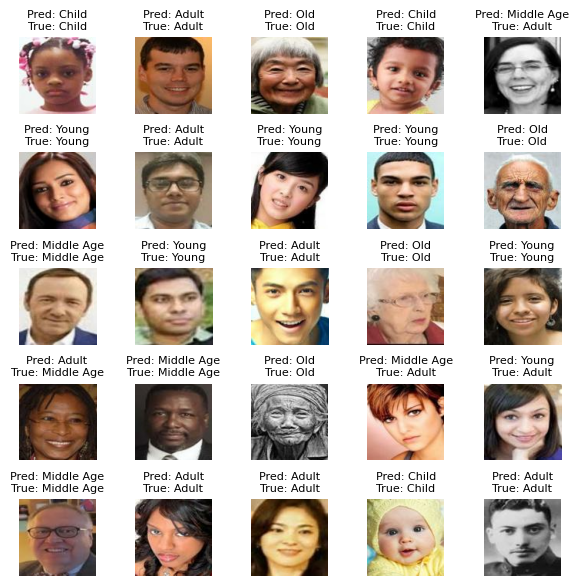

In [31]:
predicted_labels, true_labels = visualising_predictions(model, test_ds)

Visualising the confusion matrix

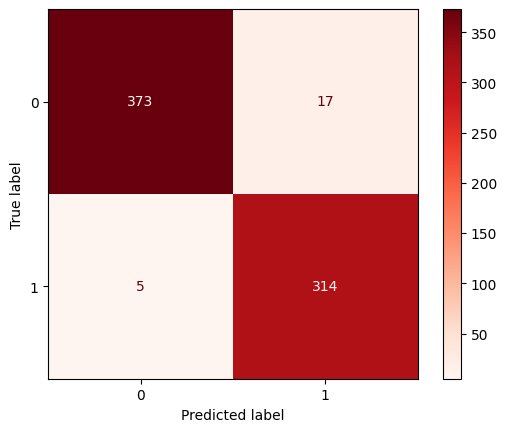

In [32]:
y_pred, y_true = plot_confusion_matrix(predicted_labels, true_labels)

Generating the classification report

In [33]:
generate_classification_report(y_pred, y_true)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       395
           1       0.67      0.84      0.74       374
           2       0.86      0.79      0.82       925
           3       0.78      0.80      0.79       408
           4       0.90      0.83      0.87       255

    accuracy                           0.83      2357
   macro avg       0.84      0.84      0.84      2357
weighted avg       0.84      0.83      0.83      2357



##STL Model 2 : Age Group Classification

This has the same model architecture as STL Model 1. However, it is fully trainable.

Model: VGG16 conv base (fully trainiable) + [128] + [out] <br>
where out layer consists of 5 nodes for age group classification.

In [35]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(seed)

from tensorflow.keras.applications import vgg16
img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')
# Load the vgg16 model with pre-trained Imagenet weights and without the top classification layer
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model.layers:
  layer.trainable = True

# Age group Classification
flatten = layers.GlobalAveragePooling2D()(base_model.output)
age_group = layers.Dense(128, activation='relu', name='age_fc1')(flatten)
age_group_out = layers.Dense(5, activation='softmax', name='age_output')(age_group)

# Single-task Model
model = models.Model(inputs=base_model.input, outputs=[age_group_out], name='st_model_2')

# Printing the model summary
model.summary()

Model: "st_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ age_fc1 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,997 (56.39 MB)

 Trainable params: 14,780,997 (56.39 MB)

 Non-trainable params: 0 (0.00 B)

Printing about the model details

In [36]:
print_about_model(model)

   Trainable Params  Non-trainable Params  Total Params  Trainable Param %
0          14780997                   0.0      14780997              100.0
Model Size in KB: 57738.27 KB
Model Size in MB: 56.39 MB

------- About model layers ------------------------------------------
1: input_layer_1 - Trainable, Output Shape: (None, 100, 100, 3)
2: block1_conv1 - Trainable, Output Shape: (None, 100, 100, 64)
3: block1_conv2 - Trainable, Output Shape: (None, 100, 100, 64)
4: block1_pool - Trainable, Output Shape: (None, 50, 50, 64)
5: block2_conv1 - Trainable, Output Shape: (None, 50, 50, 128)
6: block2_conv2 - Trainable, Output Shape: (None, 50, 50, 128)
7: block2_pool - Trainable, Output Shape: (None, 25, 25, 128)
8: block3_conv1 - Trainable, Output Shape: (None, 25, 25, 256)
9: block3_conv2 - Trainable, Output Shape: (None, 25, 25, 256)
10: block3_conv3 - Trainable, Output Shape: (None, 25, 25, 256)
11: block3_pool - Trainable, Output Shape: (None, 12, 12, 256)
12: block4_conv1 - Trainable

Plotting the model structure

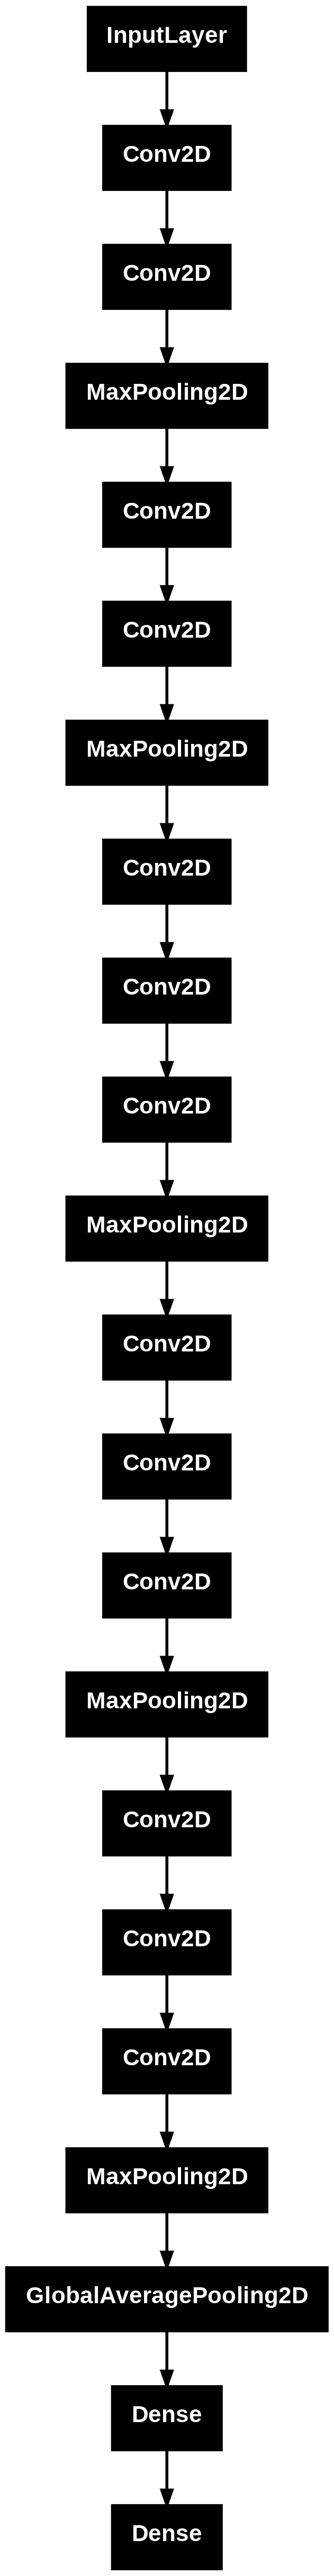

In [37]:
plot_model(model)

Compiling and training the model

In [38]:
history, checkpoint_path, mc_callback = model_compile_and_fit(model, lr=lr, train_ds=train_ds, epochs=30, val_ds=val_ds, batch_size=batch_size,
                                                              file_name="STL_VGGmodel_agegroup_classification_v2.keras")

Epoch 1/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 87s 127ms/step - accuracy: 0.5005 - loss: 1.1733 - val_accuracy: 0.6235 - val_loss: 0.8230 - learning_rate: 1.0000e-04
Epoch 2/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 73s 124ms/step - accuracy: 0.6603 - loss: 0.7671 - val_accuracy: 0.7067 - val_loss: 0.6956 - learning_rate: 1.0000e-04
Epoch 3/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 73s 124ms/step - accuracy: 0.7043 - loss: 0.6680 - val_accuracy: 0.7211 - val_loss: 0.6911 - learning_rate: 1.0000e-04
Epoch 4/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 73s 124ms/step - accuracy: 0.7478 - loss: 0.5830 - val_accuracy: 0.7301 - val_loss: 0.6734 - learning_rate: 1.0000e-04
Epoch 5/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 73s 124ms/step - accuracy: 0.7893 - loss: 0.4964 - val_accuracy: 0.7657 - val_loss: 0.5957 - learning_rate: 1.0000e-04
Epoch 6/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 73s 124ms/step - accuracy: 0.7935 - loss: 0.4794 - val_accuracy: 0.8069 - val_loss: 0.4886 - learning_rate: 1.0000e-04
Epoch 7/30
589/589 ━━━━━━━━━━━━━━━━━━━━ 72s 12

Plotting losses and accuracies of the model

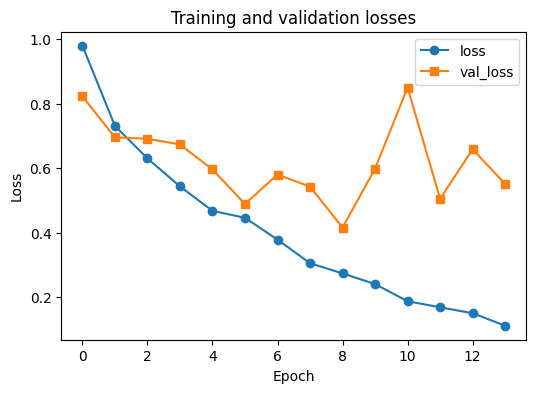

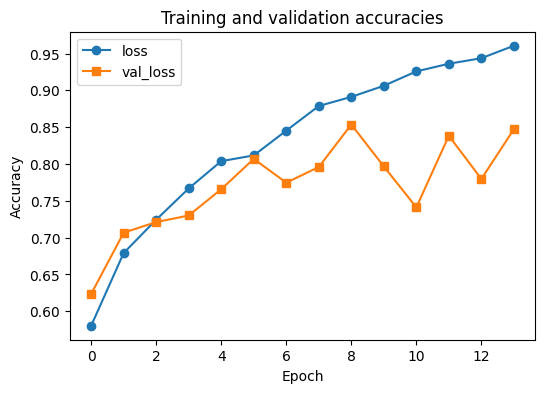

In [39]:
plotting_losses_accuracies(history)

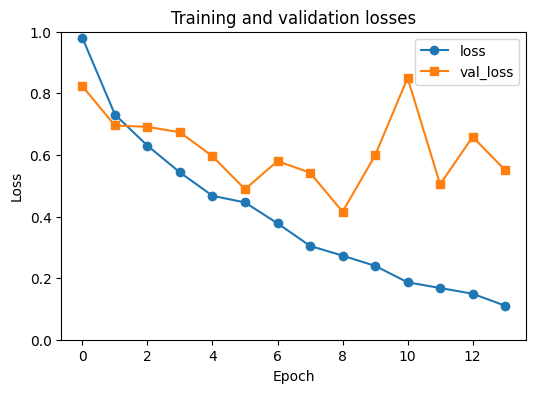

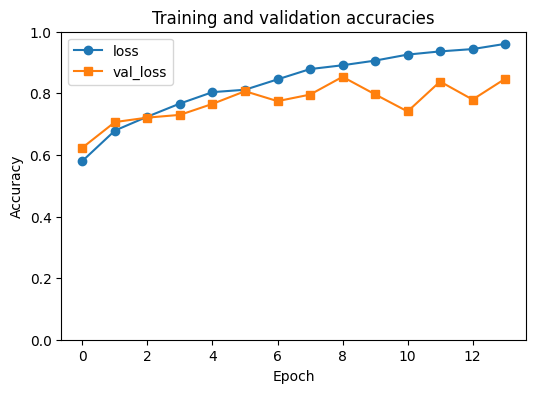

In [40]:
plotting_losses_accuracies_y_adjusted(history)

Evaluating the model on test dataset

In [41]:
model_test_results(model, checkpoint_path)

74/74 - 3s - 37ms/step - accuracy: 0.8443 - loss: 0.4231

test_loss = 0.4231, test_acc = 0.8443


Visualising a sample from model predictions on test dataset

74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


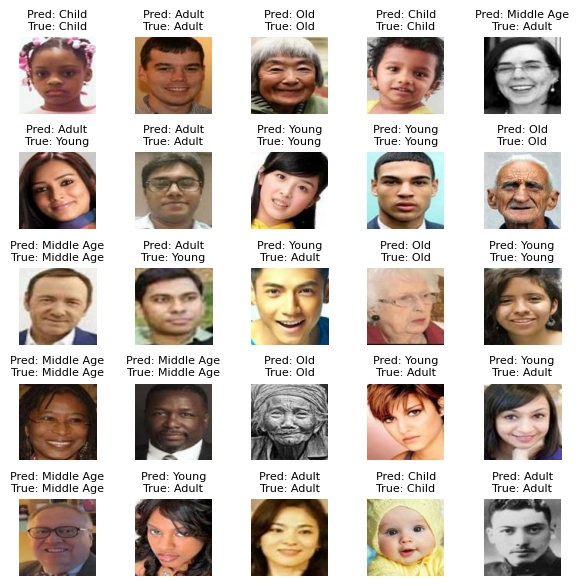

In [42]:
predicted_labels, true_labels = visualising_predictions(model, test_ds)

Visualising the confusion matrix

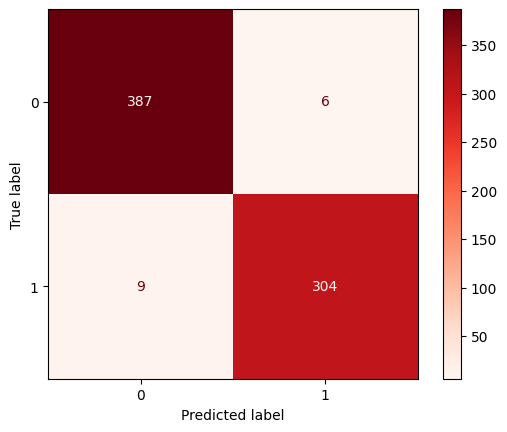

In [43]:
y_pred, y_true = plot_confusion_matrix(predicted_labels, true_labels)

Generating the classification report

In [44]:
generate_classification_report(y_pred, y_true)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       395
           1       0.71      0.81      0.76       374
           2       0.88      0.79      0.83       925
           3       0.78      0.82      0.80       408
           4       0.86      0.92      0.89       255

    accuracy                           0.84      2357
   macro avg       0.84      0.86      0.85      2357
weighted avg       0.85      0.84      0.85      2357



## References

Deng, J., Dong, W., Socher, R., Li, L.J., Li, K. and Fei-Fei, L. (2009). 'Imagenet: A large-scale hierarchical image database'. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*. IEEE, pp.248-255. Available at: 10.1109/CVPR.2009.5206848.

Deng, J., Guo, J., Ververas, E., Kotsia, I. and Zafeiriou, S. (2020). 'RetinaFace: Single-Shot Multi-Level Face Localisation in the Wild'. *2020 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*. IEEE, pp. 5202-5211. Available at: https://doi.org/10.1109/cvpr42600.2020.00525.

Simonyan, K. and Zisserman, A. (2015). 'Very Deep Convolutional Networks for Large-Scale Image Recognition'. *Proceedings of the 3rd International Conference on Learning Representations (ICLR)*. Computational and Biological Learning Society, pp.1-14. Available at: https://arxiv.org/pdf/1409.1556.

Song, Y., Zhang, Z. and Qi, H. (2017). UTKFace: A Large Scale Face Dataset. Available at: https://susanqq.github.io/UTKFace/.